# General

---

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
import descartes 
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Data Notes  

Files (by fishing gear types):  
1. Drifting longlines vessels
2. Fixed gear vessels
3. Pole and line vessels
4. Purse Seines vessels
5. Trawlers vessels
6. Trollers vessels
7. Vessels with unknown geartypes  

CVS Table Schema:
* mmsi: anonymized vessel identifier
* timestamp: unix timestamp 
* distance_from_shore: distance from shore in meters 
* distance_from_port: distance from port in meters
* speed: vessel speed in knots
* course: vessel's course over ground (represented in degrees)
* lat: latitude in decimal degrees 
* lon: longitude in decimal degrees
* is_fishing: lable indicating fishing activity
  * 0 = not fishing
  * \>0 = fishing; data values between 0 and 1 indicate the average score for the position if scored by multiple people 
  * -1 = no data  
* source: the training data batch; data was prepared by GFW, Dalhousie, and a crowd sourcing campaign (false positives are marked as false_positives)

---

In [85]:
# filepaths 
drifting_longlines_file = './data/drifting_longlines.csv'
fixed_gear_file = './data/fixed_gear.csv'
pole_and_line_file = './data/pole_and_line.csv'
purse_seines_file = './data/purse_seines.csv'
trawlers_file = './data/trawlers.csv'
trollers_file = './data/trollers.csv'
unknown_file = './data/unknown.csv'

# for mapping vessel paths later 
oceanMap = gpd.read_file('./mapping/world_map/ne_50m_ocean.shp')
atlanticMap = gpd.read_file('./mapping/atlantic_ocean/iho.shp')
crs = {'init': 'epsg:4326'}

# Exploratory Analysis 
---

## Drifting Longlines    
A drifting longline consists of a mainline kept near the surface or at a certain depth by means of regularly spaced floats and with relatively long snoods with baited hooks, evenly spaced on the mainline. Drifting longlines may be of considerable length. Some drifting longlines are set vertically, each line hanging from a float at the surface. (Source: [FAO Drifting Longlines](https://www.fao.org/fishery/en/geartype/233/en))


In [84]:
# read in data from the drifting long lines vessels file 
driftingLongLinesDF = pd.read_csv(drifting_longlines_file)

# peak at the data 
driftingLongLinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.263956e+13,1.327137e+09,232994.281250,311748.65625,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner
1,1.263956e+13,1.327137e+09,233994.265625,312410.34375,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner
2,1.263956e+13,1.327137e+09,233994.265625,312410.34375,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner
3,1.263956e+13,1.327143e+09,233994.265625,315417.37500,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner
4,1.263956e+13,1.327143e+09,233996.390625,316172.56250,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner


In [28]:
# check data characteristics 
driftingLongLinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.396873e+07,1.396873e+07,1.396873e+07,1.396873e+07,1.396863e+07,1.396863e+07,1.396873e+07,1.396873e+07,1.396873e+07
mean,1.293850e+14,1.434290e+09,5.845311e+05,7.897505e+05,5.464779e+00,1.814876e+02,-8.997629e+00,3.758693e+00,-9.743015e-01
std,7.887357e+13,3.984275e+07,5.420068e+05,6.915438e+05,4.043567e+00,1.050503e+02,2.439311e+01,1.095971e+02,2.119947e-01
min,5.601266e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.519017e+01,-1.800000e+02,-1.000000e+00
25%,6.260384e+13,1.410706e+09,1.019092e+05,2.130206e+05,2.100000e+00,9.070000e+01,-2.601550e+01,-8.808668e+01,-1.000000e+00
50%,1.184859e+14,1.447302e+09,4.576393e+05,6.375249e+05,5.500000e+00,1.811000e+02,-1.497954e+01,-1.716495e+00,-1.000000e+00
75%,1.980758e+14,1.466506e+09,9.603664e+05,1.210432e+06,8.500000e+00,2.711000e+02,4.485790e+00,1.009811e+02,-1.000000e+00
max,2.812058e+14,1.480032e+09,4.430996e+06,7.181037e+06,1.023000e+02,5.110000e+02,8.333266e+01,1.799938e+02,1.000000e+00


Many records with course values of 511, which is larger than 360 degrees. That represents not available data according to the [US Coast Guard Class A AIS Position Report Documentation](https://www.navcen.uscg.gov/?pageName=AISMessagesA).

In [29]:
# data shape 
driftingLongLinesDF.shape

(13968727, 10)

In [30]:
# drop rows without data for is_fishing
driftingLongLinesDF = driftingLongLinesDF[driftingLongLinesDF['is_fishing'] != -1]
driftingLongLinesDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
330,1.263956e+13,1.338658e+09,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
570,1.263956e+13,1.345706e+09,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner
638,1.263956e+13,1.346391e+09,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner
677,1.263956e+13,1.346825e+09,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner


In [31]:
# recheck data shape 
driftingLongLinesDF.shape

(219741, 10)

In [32]:
# check label distribution
driftingLongLinesDF['is_fishing'].value_counts()

1.000000    138163
0.000000     79574
0.666667      1076
0.333333       809
0.750000       110
0.250000         9
Name: is_fishing, dtype: int64

In [33]:
# recheck data characteristics after dropping rows missing is_fishing data 
driftingLongLinesDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,2.197410e+05,2.197410e+05,2.197410e+05,2.197410e+05,219741.000000,219741.000000,219741.000000,219741.000000,219741.000000
mean,1.368067e+14,1.413013e+09,5.113833e+05,7.021433e+05,5.687254,181.330646,-8.010195,4.203933,0.633631
std,8.173824e+13,1.594068e+07,4.882178e+05,6.183033e+05,3.787542,103.866320,23.478505,110.809452,0.479725
min,5.601266e+12,1.338572e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-45.302502,-179.999115,0.000000
25%,6.260384e+13,1.407986e+09,9.338936e+04,1.684358e+05,2.600000,91.699997,-23.396667,-79.919830,0.000000
50%,1.220965e+14,1.411405e+09,4.179383e+05,5.699421e+05,5.700000,179.800003,-15.034370,2.768880,1.000000
75%,2.089256e+14,1.418502e+09,7.719319e+05,1.115062e+06,8.700000,271.399994,3.925500,73.103127,1.000000
max,2.812058e+14,1.451623e+09,2.185458e+06,3.117979e+06,102.300003,360.000000,73.066498,179.991486,1.000000


In [34]:
# check for null values
driftingLongLinesDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [35]:
# reformat unix timestamps into datetime
driftingLongLinesFormattedTimestamps = pd.to_datetime(driftingLongLinesDF['timestamp'], unit = 's')
driftingLongLinesDF.insert(2, 'timestamp_reformat', driftingLongLinesFormattedTimestamps)
driftingLongLinesDF.head() 

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
330,1.263956e+13,1.338658e+09,1970-01-01 00:00:01.338657590,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,1970-01-01 00:00:01.340093574,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
570,1.263956e+13,1.345706e+09,1970-01-01 00:00:01.345705580,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner
638,1.263956e+13,1.346391e+09,1970-01-01 00:00:01.346390674,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner
677,1.263956e+13,1.346825e+09,1970-01-01 00:00:01.346825465,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner


In [36]:
# count the unique mmsi's
len(pd.unique(driftingLongLinesDF['mmsi']))

110

To visualize the data, going to group records by the vessel MMSI's and plot one vessels path on a map. Start by grouping the data, grabbing the first vessel's records, and then converting data into a GeoDataFrame. Then, plot the path using shape files in the mapping folder. 

In [55]:
# group the drifting long line vessels by their mmsi's 
driftingLongLinesMMSIGroups = driftingLongLinesDF.sort_values(['mmsi', 'timestamp_reformat']).groupby('mmsi')

# peak at first 3 rows in each resulting group 
driftingLongLinesMMSIGroups.head(3)

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
1137687,5.601266e+12,1.420091e+09,1970-01-01 00:00:01.420091425,590250.687500,1.802076e+06,0.2,1.800000,-22.851770,-24.182766,1.0,gfw
1137704,5.601266e+12,1.420102e+09,1970-01-01 00:00:01.420101927,573515.375000,1.787757e+06,4.0,321.899994,-22.749702,-24.293646,1.0,gfw
1137705,5.601266e+12,1.420102e+09,1970-01-01 00:00:01.420101987,573515.375000,1.787757e+06,3.7,322.500000,-22.748981,-24.294298,1.0,gfw
330,1.263956e+13,1.338658e+09,1970-01-01 00:00:01.338657590,111123.328125,1.475938e+05,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,1970-01-01 00:00:01.340093574,329078.531250,3.623638e+05,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
...,...,...,...,...,...,...,...,...,...,...,...
693665,2.810605e+14,1.348942e+09,1970-01-01 00:00:01.348941588,26869.398438,2.183819e+05,0.3,158.899994,47.763962,139.535767,0.0,dalhousie_longliner
694325,2.810605e+14,1.359740e+09,1970-01-01 00:00:01.359739539,0.000000,2.942716e+04,0.0,226.899994,42.826355,132.418411,0.0,dalhousie_longliner
13863613,2.812058e+14,1.402897e+09,1970-01-01 00:00:01.402897402,526676.687500,7.122669e+05,5.9,157.699997,-6.458367,-28.446316,1.0,crowd_sourced
13863614,2.812058e+14,1.402904e+09,1970-01-01 00:00:01.402904063,548603.000000,7.260848e+05,11.3,136.000000,-6.614067,-28.313932,1.0,crowd_sourced


In [59]:
# plot the ship course of the first drifting long line vessel
# get the first vessel data  
driftingLongLineVesselPlotDF = driftingLongLinesMMSIGroups.get_group(list(driftingLongLinesMMSIGroups.groups.keys())[0])

# convert longitude and latitude to Points so we can convert pandas dataframe to GeoDataFrame 
dLLPoints = [Point(xy) for xy in zip(driftingLongLineVesselPlotDF['lon'], driftingLongLineVesselPlotDF['lat'])]

# create GeoDataFrame 
dLLGeoDF = gpd.GeoDataFrame(driftingLongLineVesselPlotDF, crs = crs, geometry = dLLPoints)
dLLGeoDF.head()

C:\Users\prodb\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,geometry
1137687,5.601266e+12,1.420091e+09,1970-01-01 00:00:01.420091425,590250.6875,1802075.875,0.2,1.800000,-22.851770,-24.182766,1.0,gfw,POINT (-24.18277 -22.85177)
1137704,5.601266e+12,1.420102e+09,1970-01-01 00:00:01.420101927,573515.3750,1787757.000,4.0,321.899994,-22.749702,-24.293646,1.0,gfw,POINT (-24.29365 -22.74970)
1137705,5.601266e+12,1.420102e+09,1970-01-01 00:00:01.420101987,573515.3750,1787757.000,3.7,322.500000,-22.748981,-24.294298,1.0,gfw,POINT (-24.29430 -22.74898)
1137706,5.601266e+12,1.420102e+09,1970-01-01 00:00:01.420102335,573045.2500,1787563.750,3.1,334.700012,-22.742298,-24.298233,1.0,gfw,POINT (-24.29823 -22.74230)
1137707,5.601266e+12,1.420103e+09,1970-01-01 00:00:01.420103126,572576.5000,1787371.000,4.6,0.000000,-22.734077,-24.300257,1.0,gfw,POINT (-24.30026 -22.73408)


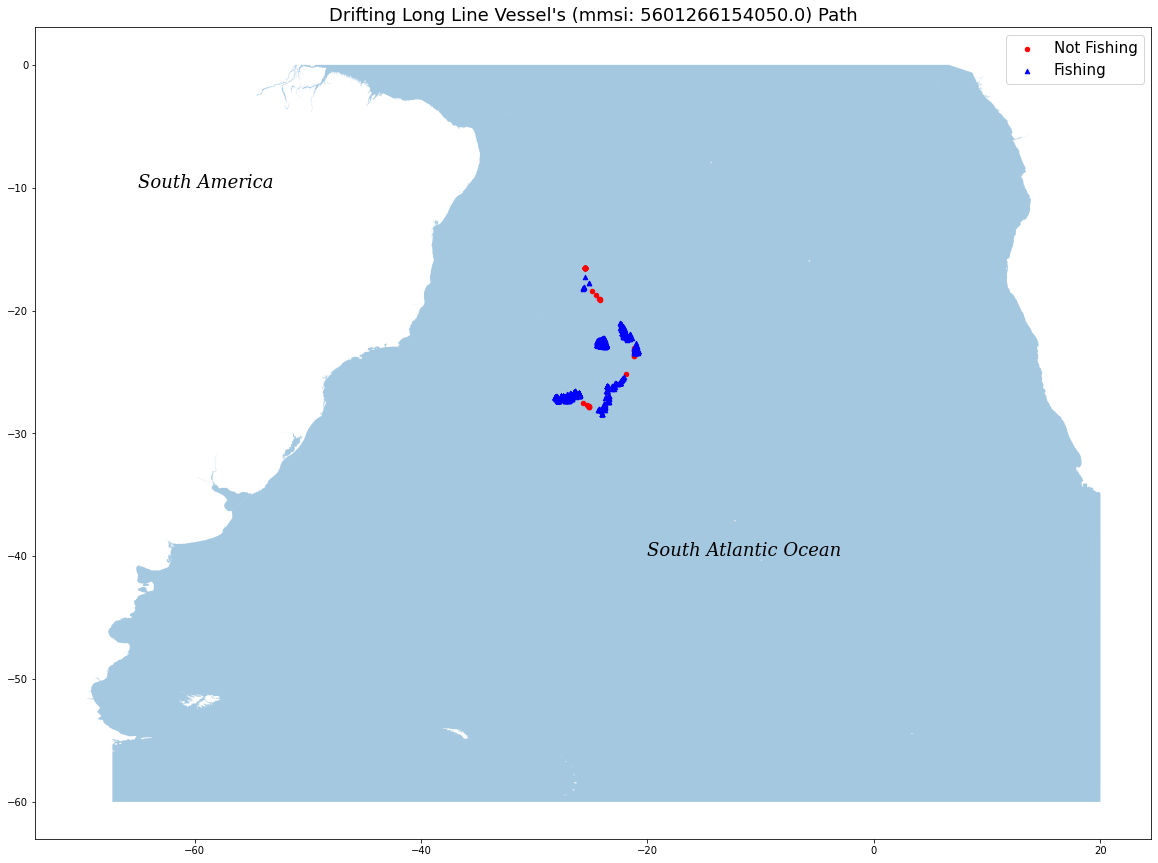

In [121]:
# create the plot  
fig, ax = plt.subplots(figsize = (20, 20)) 
atlanticMap.plot(ax = ax, alpha = 0.4)
plt.title('Drifting Long Line Vessel\'s (mmsi: ' + str(list(driftingLongLinesMMSIGroups.groups.keys())[0]) + ') Path', fontdict = {'fontsize': 18})
dLLGeoDF[dLLGeoDF['is_fishing'] <= 0.5].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Not Fishing')
dLLGeoDF[dLLGeoDF['is_fishing'] > 0.5].plot(ax = ax, markersize = 20, color = 'blue', marker = '^', label = 'Fishing')
ax.text(-20, -40, 'South Atlantic Ocean', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
ax.text(-65, -10, 'South America', fontdict = {'fontsize': 18, 'fontstyle': 'italic', 'fontfamily': 'serif'})
plt.legend(prop = {'size': 15})

## Fixed Gear  
Fixed gear generally means trapping or potting, and gillnetting, where the catching implement is set, soaked and later retrieved. (Source: [FAO Gillnets](https://www.fao.org/fishery/en/geartype/247/en))

In [134]:
# read in data from the fixed gear vessels file 
fixedGearDF = pd.read_csv(fixed_gear_file)

# peak at data 
fixedGearDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.572519e+12,1.347664e+09,0.0,36054.625000,0.0,0.000000,42.798748,-8.944992,-1.0,gfw
1,7.572519e+12,1.348056e+09,0.0,36054.625000,0.0,0.000000,42.798717,-8.945075,-1.0,gfw
2,7.572519e+12,1.350409e+09,0.0,90970.296875,0.0,198.199997,43.106419,-9.215466,-1.0,gfw
3,7.572519e+12,1.350410e+09,0.0,90970.296875,0.0,186.899994,43.106434,-9.215431,-1.0,gfw
4,7.572519e+12,1.350411e+09,0.0,90970.296875,0.0,190.500000,43.106430,-9.215442,-1.0,gfw


In [123]:
# check data characteristics, same 511 values for course (explained above after code block 28)
fixedGearDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06
mean,1.530752e+14,1.421486e+09,3.761878e+04,5.989848e+04,2.227195e+00,1.877938e+02,5.095086e+01,1.274018e+00,-9.659100e-01
std,8.976383e+13,3.782830e+07,1.090188e+05,1.269729e+05,3.412790e+00,1.177506e+02,5.894565e+00,8.512244e+00,2.173124e-01
min,7.572519e+12,1.325625e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.326460e+01,-1.792441e+02,-1.000000e+00
25%,8.878018e+13,1.387594e+09,0.000000e+00,5.656715e+03,0.000000e+00,7.740000e+01,4.745566e+01,-3.909275e+00,-1.000000e+00
50%,1.305289e+14,1.427254e+09,0.000000e+00,2.690659e+04,1.000000e-01,2.055000e+02,5.050242e+01,-2.333808e+00,-1.000000e+00
75%,2.616830e+14,1.455255e+09,3.413126e+04,5.514391e+04,3.800000e+00,2.870000e+02,5.602126e+01,8.220293e+00,-1.000000e+00
max,2.802913e+14,1.480032e+09,3.099833e+06,1.181676e+07,1.023000e+02,5.110000e+02,8.479108e+01,1.709277e+02,1.000000e+00


In [124]:
# data shape 
fixedGearDF.shape

(1559137, 10)

In [135]:
# drop rows without data for is_fishing
fixedGearDF = fixedGearDF[fixedGearDF['is_fishing'] != -1]
fixedGearDF.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


In [126]:
# recheck data shape 
fixedGearDF.shape

(41858, 10)

In [127]:
# check label distribution 
fixedGearDF['is_fishing'].value_counts()

0.000000    29790
1.000000    10665
0.666667      538
0.250000      423
0.333333      405
0.800000       29
0.750000        6
0.400000        2
Name: is_fishing, dtype: int64

In [128]:
# recheck data characteristics after dropping rows missing is_fishing data 
fixedGearDF.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,4.185800e+04,4.185800e+04,4.185800e+04,4.185800e+04,41858.000000,41858.000000,41858.000000,41858.000000,41858.000000
mean,1.405469e+14,1.430883e+09,2.314125e+04,4.419514e+04,1.842260,207.619382,51.379668,0.837540,0.269791
std,8.812204e+13,1.115849e+07,9.285800e+04,9.696492e+04,3.140728,119.548799,6.076739,8.988599,0.435842
min,7.572519e+12,1.340576e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-0.061667,-55.494328,0.000000
25%,5.911250e+13,1.424233e+09,0.000000e+00,5.385033e+03,0.000000,107.699997,49.612662,-7.189246,0.000000
50%,1.061505e+14,1.427413e+09,0.000000e+00,2.624817e+04,0.000000,226.800003,51.133953,-2.960934,0.000000
75%,2.259868e+14,1.439289e+09,1.711682e+04,4.753829e+04,2.700000,308.200012,57.151646,11.366385,1.000000
max,2.802913e+14,1.451623e+09,1.448151e+06,1.472929e+06,102.300003,511.000000,59.587173,47.079002,1.000000


Still records with 511 course value. That will be fixed later.

In [129]:
# check for null values 
fixedGearDF.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [136]:
# reformat unix timestamps into datetime 
fixedGearFormattedTimestamps = pd.to_datetime(fixedGearDF['timestamp'], unit = 's')
fixedGearDF.insert(2, 'timestamp_reformat', fixedGearFormattedTimestamps)
fixedGearDF.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,2015-01-02 07:44:07,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,2015-01-02 07:56:08,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,2015-01-02 08:08:09,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,2015-01-02 08:23:08,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,2015-01-02 08:38:07,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


## Pole and Lines  
A pole and line consists of a hooked line attached to a pole. This method is common to sport fisheries (angling) but it is also used in commercial fisheries. Fishing rods/poles are made of wood (including bamboo, also constructed of split cane) and increasingly of fiberglass. (Source: [FAO Pole and Lines](https://www.fao.org/fishery/en/geartype/314/en))

## Purse Seines  
A purse seine is made of a long wall of netting framed with floatline and leadline (usually, of equal or longer length than the former) and having purse rings hanging from the lower edge of the gear, through which runs a purse line made from steel wire or rope which allow the pursing of the net. For most of the situation, it is the most efficient gear for catching large and small pelagic species that is shoaling. (Source: [FAO Purse \Sseines](https://www.fao.org/fishery/en/geartype/249/en))


## Trawlers  
The trawls are cone-shaped net (made from two, four or more panels) which are towed, by one or two boats, on the bottom or in midwater (pelagic). The cone-shaped body ends in a bag or coded. The horizontal opening of the gear while it is towed is maintained by beams, otter boards or by the distance between the two towing vessels (pair trawling). Floats and weights and/or hydrodynamic devices provide for the vertical opening. Two parallel trawls might be rigged between two otter boards (twin trawls). The mesh size in the codend or special designed devices is used to regulate the size and species to be captured. (Source: [FAO Trawls](https://www.fao.org/fishery/en/geartype/103/en))



## Trollers  
A trolling line consists of a line with natural or artificial baited hooks and is trailed by a vessel near the surface or at a certain depth. Several lines are often towed at the same time, by using outriggers to keep the lines away from the wake of the vessel. The line are hauled by hand or with small winches. A piece of rubber is often included in each line as a shock absorber. (Source: [FAO Trolling Lines](https://www.fao.org/fishery/en/geartype/235/en))


## Unknown  
Vessels with unkown fishing gear types. 

# Data Wrangling 

## Combine Data
Combine the different vessel types data into one training set dataframe. 